In [1]:
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.stats import smetrics
# from preproc_tools import get_fr_by_sample
import numpy as np
#import compute_population_distance
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from ephysvibe.stats import smetrics
from ephysvibe.trials.spikes import firing_rate
seed=1997

In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Function to compute the angle between two vectors
def compute_angle_between_vectors(vec1, vec2):
    
    # Compute the dot product
    dot_product = np.dot(vec1, vec2)
    # Compute the norms (magnitudes)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    # Compute the cosine of the angle
    cos_theta = dot_product / (norm_vec1 * norm_vec2)
    # Return the angle in radians
    return np.arccos(cos_theta)

In [4]:
# x = np.array([[2, 0, 2], [2, 2, 3]])
# x.shape
# u=np.array([2,1])
# v=np.array([1,2])
# print(x)
# print(pdist(x,metric='cosine'))
# np.arccos(u.dot(v)/(np.norm(u)*np.norm(v)))*180/np.pi
# distance.cosine(x[0],x[1])
# A = np.array([[1, 1]])
# B = np.array([[1, 0]])
# cosine_similarity(A)
# (((1-cosine_similarity(A))/2)*np.pi)*360/(2*np.pi)
# pdist(A,metric='euclidean')

In [5]:
u=np.array([1,0,0])
v=np.array([0,1,0])
print(compute_angle_between_vectors(u, v)*180/np.pi)
u=np.array([1,0,0])
v=np.array([0,-1,0])
print(compute_angle_between_vectors(u, v)*180/np.pi)


90.0
90.0


### Start preprocessing

In [4]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [149]:
1050+400+550

2000

In [150]:
import pandas as pd
import preproc_tools
seed=1997

In [7]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    rng = np.random.default_rng(seed)
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        preproc_tools.get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]

    print("start iterations")
    distance_data = []
    for _ in tqdm(range(1000)):
        dist = get_distance(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_dist_n_nn = []
    all_dist_fake_n_nn = []
    for asc in distance_data:
        all_dist_n_nn.append(asc["dist_n_nn"])
        all_dist_fake_n_nn.append(asc["dist_fake_n_nn"])
    all_dist_n_nn = np.array(all_dist_n_nn, dtype=np.float32)
    all_dist_fake_n_nn = np.array(all_dist_fake_n_nn, dtype=np.float32)
    res["dist_n_nn"] = all_dist_n_nn
    res["dist_fake_n_nn"] = all_dist_fake_n_nn
    res["n_neurons"] = asc["n_neurons"]

    res = Results("population_distance.py", input, distance=res)
    return res

In [8]:

def scrum_neutralsize_samepool(data, ntr, rng):

    nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [9]:
def get_distance(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []
    if metric == 'cosine':
        model = PCA(n_components=select_n_neu).fit(reshape_pc.reshape(select_n_neu,-1).T)
        C = model.components_
        reshape_pc = reshape_pc - C.reshape(-1,1,1)


    for i in range(reshape_pc.shape[-1]):

        dist_n_nn.append(
            pdist(np.array((reshape_pc[:, 0, i], reshape_pc[:, 1, i])), metric=metric)
        )
        dist_fake_n_nn.append(
            pdist(np.array((fr_groups[:, 0, i], fr_groups[:, 1, i])), metric=metric)
        )

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


Compute distances


100%|██████████| 530/530 [00:08<00:00, 63.13it/s]


start iterations


  0%|          | 0/1000 [00:00<?, ?it/s]

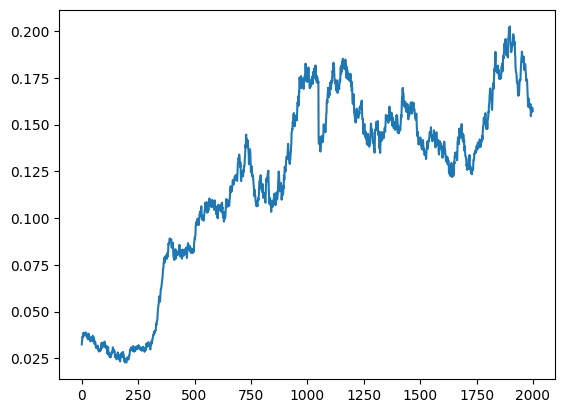

  0%|          | 0/1000 [07:02<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (100,2,2000) (10000,1,1) 

In [11]:
res = compute_distance(**preprocessing, **paths)

In [30]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [22]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

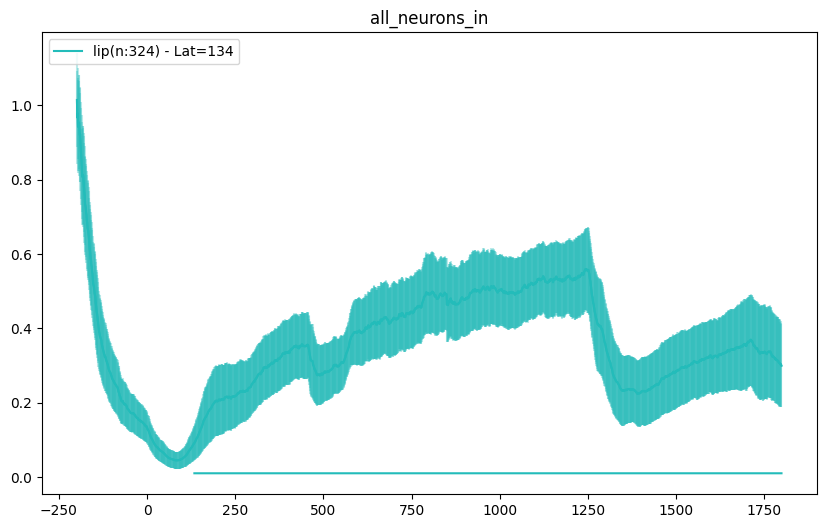

In [24]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip']):
    d=res.distance['dist_n_nn']
    fd=res.distance['dist_fake_n_nn']

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200

    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_in')

### Test velocity

In [6]:
from scipy.signal.windows import gaussian
def define_kernel(w_size, w_std, fs):
    kernel = gaussian(M=w_size * fs, std=w_std * fs)
    kernel = kernel / sum(kernel)  # area of the kernel must be one
    return kernel
def convolve_signal(
    arr: np.ndarray,
    fs: int = 1000,
    w_size: float = 0.1,
    w_std: float = 0.015,
    axis: int = 1,
):
    # define kernel for convolution
    kernel = define_kernel(w_size, w_std, fs=fs)
    conv = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode="same"), axis=axis, arr=arr
    )
    return conv * fs

In [136]:
from ephysvibe.trials import align_trials, select_trials
def select_trials_by_percentile(x: np.ndarray, mask: np.ndarray = None):
    ntr = x.shape[0]
    if mask is None:
        mask = np.full(ntr, True)

    mntr = x[mask].shape[0]

    if mntr < 2:
        return np.full(ntr, True)
    mean_trs = np.mean(x, axis=1)

    q25, q75 = np.percentile(mean_trs[mask], [25, 75])
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr
    lower_limit = q25 - 1.5 * iqr

    q1mask = mean_trs > lower_limit
    q2mask = mean_trs < upper_limit

    qmask = np.logical_and(q1mask, q2mask)
    return qmask


def check_trials(x, cerotr, percentile):
    masknocero = np.full(x.shape[0], True)
    maskper = np.full(x.shape[0], True)
    if cerotr:
        masknocero = np.sum(x, axis=1) != 0
    if percentile:
        maskper = select_trials_by_percentile(x, masknocero)
    mask = np.logical_and(masknocero, maskper)
    if np.sum(mask) < 5:
        mask = np.full(x.shape[0], True)
    return mask

def get_fr_by_sample(
    neu,
    time_before_son: str,
    time_before_t1on: str,
    sp_son: str,
    sp_t1on: str,
    mask_son: str,
    start_sample: int,
    end_sample: int,
    start_test: int,
    end_test: int,
    n_test,
    min_trials,
    min_neu=False,
    nonmatch=True,
    avgwin=50,
    step=20,
    # n_sp_sec=5,
    norm=False,
    zscore=False,
    include_nid=None,
    cerotr=False,
    percentile=False,
):
    if include_nid is not None:
        nid = neu.get_neuron_id()
        if not (nid in include_nid):
            return None

    idx_start_sample = int((getattr(neu, time_before_son) + start_sample))
    idx_end_sample = int((getattr(neu, time_before_son) + end_sample))
    idx_start_test = int((getattr(neu, time_before_t1on) + start_test))
    idx_end_test = int((getattr(neu, time_before_t1on) + end_test))
    sampleon = getattr(neu, sp_son)
    t1on = getattr(neu, sp_t1on)
    mask_son = getattr(neu, mask_son)

    # Select trials aligned to sample onset

    sample_id = neu.sample_id[mask_son]

    # Build masks to select trials with match in the n_test
    mask_match = np.where(
        neu.test_stimuli[mask_son, n_test - 1] == neu.sample_id[mask_son],
        True,
        False,
    )
    mask_neu = neu.sample_id[mask_son] == 0
    # Build masks to select trials with the selected number of test presentations
    max_test = neu.test_stimuli[mask_son].shape[1]
    mask_ntest = (max_test - np.sum(np.isnan(neu.test_stimuli[mask_son]), axis=1)) > (
        n_test - 1
    )

    if nonmatch:  # include neutral and trials without a match before n_ntest (included)
        mask_match_neu = np.logical_or(mask_ntest, mask_neu)
    else:  # include neutral and trials with a match in the n_test
        mask_match_neu = np.logical_or(mask_match, mask_neu)
    if np.sum(mask_match_neu) < 20:
        return None

    #Average fr across time


    avg_sample_on = firing_rate.moving_average(
        sampleon[mask_match_neu], win=avgwin, step=step
    )
    avg_sample_on = convolve_signal(
        avg_sample_on,fs = 1000/step,w_size=0.1,w_std=0.040,axis=-1
    )[:, :idx_end_sample]

    avg_test1_on = firing_rate.moving_average(t1on[mask_match_neu], win=avgwin, step=step)
    avg_test1_on = convolve_signal(
        avg_test1_on,fs = 1000/step,w_size=0.1,w_std=0.040,axis=-1
    )[:, idx_start_test:]

    # Concatenate sample and test aligned data
    sp = np.concatenate((avg_sample_on, avg_test1_on), axis=1)
    # Check fr
    # ms_fr = np.nanmean(sp) * 1000 > n_sp_sec
    # if not ms_fr:
    #     return None
    # Check number of trials
    sample_id = neu.sample_id[mask_son][mask_match_neu]
    samples = [0, 11, 15, 55, 51]
    if min_neu:
        sample_fr = sp[np.where(sample_id == 0, True, False)]
        if sample_fr.shape[0] < min_trials:
            return None
    else:
        for s_id in samples:
            sample_fr = sp[np.where(sample_id == s_id, True, False)]
            if sample_fr.shape[0] < min_trials:
                return None
    if norm == True:
        spmax = 1 if np.nanmax(sp) == 0 else np.nanmax(sp)
        sp = sp / spmax
    if zscore == True:
        sp_std = np.std(sp, ddof=1, axis=0)
        sp_std = np.where(sp_std == 0, 1, sp_std)
        sp = (sp - np.mean(sp, axis=0).reshape(1, -1)) / sp_std.reshape(1, -1)
    # Get trials grouped by sample
    fr_samples = select_trials.get_sp_by_sample(sp, sample_id, samples=samples)

    # check trials
    for isamp in fr_samples.keys():
        if ~np.all((np.isnan(fr_samples[isamp]))):
            masktr = check_trials(fr_samples[isamp], cerotr, percentile)
            fr_samples[isamp] = fr_samples[isamp][masktr]
            if fr_samples[isamp].shape[0] < min_trials:
                return None

    if fr_samples is None:
        return None

    return fr_samples

def get_vel_by_sample(
    neu,
    time_before_son: str,
    time_before_t1on: str,
    sp_son: str,
    sp_t1on: str,
    mask_son: str,
    start_sample: int,
    end_sample: int,
    start_test: int,
    end_test: int,
    n_test,
    min_trials,
    min_neu=False,
    nonmatch=True,
    avgwin=50,
    step=20,
    # n_sp_sec=5,
    norm=False,
    zscore=False,
    include_nid=None,
    cerotr=False,
    percentile=False,
):
    if include_nid is not None:
        nid = neu.get_neuron_id()
        if not (nid in include_nid):
            return None

    idx_start_sample = int((getattr(neu, time_before_son) + start_sample)/step)
    idx_end_sample = int((getattr(neu, time_before_son) + end_sample)/step)
    idx_start_test = int((getattr(neu, time_before_t1on) + start_test)/step)
    idx_end_test = int((getattr(neu, time_before_t1on) + end_test)/step)
    sampleon = getattr(neu, sp_son)
    t1on = getattr(neu, sp_t1on)
    mask_son = getattr(neu, mask_son)

    # Select trials aligned to sample onset

    sample_id = neu.sample_id[mask_son]

    # Build masks to select trials with match in the n_test
    mask_match = np.where(
        neu.test_stimuli[mask_son, n_test - 1] == neu.sample_id[mask_son],
        True,
        False,
    )
    mask_neu = neu.sample_id[mask_son] == 0
    # Build masks to select trials with the selected number of test presentations
    max_test = neu.test_stimuli[mask_son].shape[1]
    mask_ntest = (max_test - np.sum(np.isnan(neu.test_stimuli[mask_son]), axis=1)) > (
        n_test - 1
    )

    if nonmatch:  # include neutral and trials without a match before n_ntest (included)
        mask_match_neu = np.logical_or(mask_ntest, mask_neu)
    else:  # include neutral and trials with a match in the n_test
        mask_match_neu = np.logical_or(mask_match, mask_neu)
    if np.sum(mask_match_neu) < 20:
        return None

    #Average fr across time


    avg_sample_on = firing_rate.moving_average(
        sampleon[mask_match_neu], win=avgwin, step=step
    )
    avg_sample_on = convolve_signal(
        avg_sample_on,fs = 1000/step,w_size=0.1,w_std=0.040,axis=-1
    )[:, :idx_end_sample]

    avg_test1_on = firing_rate.moving_average(t1on[mask_match_neu], win=avgwin, step=step)
    avg_test1_on = convolve_signal(
        avg_test1_on,fs = 1000/step,w_size=0.1,w_std=0.040,axis=-1
    )[:, idx_start_test:]

    # Concatenate sample and test aligned data
    sp = np.concatenate((avg_sample_on, avg_test1_on), axis=1)
    # Check fr
    # ms_fr = np.nanmean(sp) * 1000 > n_sp_sec
    # if not ms_fr:
    #     return None
    # Check number of trials
    sample_id = neu.sample_id[mask_son][mask_match_neu]
    samples = [0, 11, 15, 55, 51]
    if min_neu:
        sample_fr = sp[np.where(sample_id == 0, True, False)]
        if sample_fr.shape[0] < min_trials:
            return None
    else:
        for s_id in samples:
            sample_fr = sp[np.where(sample_id == s_id, True, False)]
            if sample_fr.shape[0] < min_trials:
                return None
    if norm == True:
        spmax = 1 if np.nanmax(sp) == 0 else np.nanmax(sp)
        sp = sp / spmax
    if zscore == True:
        sp_std = np.std(sp, ddof=1, axis=0)
        sp_std = np.where(sp_std == 0, 1, sp_std)
        sp = (sp - np.mean(sp, axis=0).reshape(1, -1)) #/ sp_std.reshape(1, -1)

    # Compute speed

    sp = np.diff(sp,n=1,axis=-1) / step
    #sp = (convolve_signal(sp,fs = 1000,w_size=0.1,w_std=0.015,axis=-1))
    # # zscore velocity
    # sp_std = np.std(sp, ddof=1, axis=0)
    # sp_std = np.where(sp_std == 0, 1, sp_std)
    # sp = (sp - np.mean(sp, axis=0).reshape(1, -1)) / sp_std.reshape(1, -1)
    #sp = np.abs(sp)
    # Get trials grouped by sample
    fr_samples = select_trials.get_sp_by_sample(sp, sample_id, samples=samples)
    # check trials
    for isamp in fr_samples.keys():
        if ~np.all((np.isnan(fr_samples[isamp]))):
            masktr = check_trials(fr_samples[isamp], cerotr, percentile)
            fr_samples[isamp] = fr_samples[isamp][masktr]
            if fr_samples[isamp].shape[0] < min_trials:
                return None

    if fr_samples is None:
        return None

    return fr_samples


In [197]:
# def scrum_neutralsize_samepool(data, ntr, rng):

#     nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
#     size_nn = nn.shape[0]

#     idx_tr = rng.choice(size_nn, size=ntr, replace=False)
#     nn_trs = nn[idx_tr]

#     idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
#     neutral_trs = data["0"][idx_tr]

#     meanfr0 = np.mean(neutral_trs, axis=0)
#     meanfr11 = np.mean(nn_trs, axis=0)
#     meanfr15 = np.mean(nn_trs, axis=0)
#     meanfr51 = np.mean(nn_trs, axis=0)
#     meanfr55 = np.mean(nn_trs, axis=0)

#     all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

#     idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
#     g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
#     g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

#     return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

def scrum_neutralsize_samepool(data, ntr, rng):

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]
    meanfr0 = np.mean(neutral_trs, axis=0)

    nn_trs=[]

    idx_tr = rng.choice(data["11"].shape[0], size=int(ntr/4), replace=False)
    nn_trs.append(data["11"][idx_tr])
    meanfr11 = np.mean(data["11"][idx_tr], axis=0)
    idx_tr = rng.choice(data["15"].shape[0], size=int(ntr/4), replace=False)
    nn_trs.append(data["15"][idx_tr])
    meanfr15 = np.mean(data["15"][idx_tr], axis=0)
    idx_tr = rng.choice(data["51"].shape[0], size=int(ntr/4), replace=False)
    nn_trs.append(data["51"][idx_tr])
    meanfr51 = np.mean(data["51"][idx_tr], axis=0)
    idx_tr = rng.choice(data["55"].shape[0], size=int(ntr/4), replace=False)
    nn_trs.append(data["55"][idx_tr])
    meanfr55 = np.mean(data["55"][idx_tr], axis=0)

    all_s = np.concatenate((neutral_trs, np.concatenate(nn_trs,axis=0)), axis=0)

    idx_tr = rng.choice(len(all_s), size=len(all_s), replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [ ]:
def scrum_neutralsize_samepool2(data, ntr, rng):

    nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [138]:
def get_speed(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []



    distv_n_nn,distv_fake_n_nn=[],[]

    for i in range(reshape_pc.shape[-1]):

        pos0 = reshape_pc[:, 0, i]
        pos1 = reshape_pc[:, 1, i]

        pos0g = fr_groups[:, 0, i]
        pos1g = fr_groups[:, 1, i]
        
        if metric == 'euclidean':
            dist_n_nn.append(
                pdist(np.array((pos0, pos1)), metric=metric)
            )
            dist_fake_n_nn.append(
                pdist(np.array((pos0g, pos1g)), metric=metric)
            )
        if metric == 'cosine':
            dist_n_nn.append(
                compute_angle_between_vectors(pos0, pos1)
            )
            dist_fake_n_nn.append(
                compute_angle_between_vectors(pos0g, pos1g)
            )
     
                    

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "distv_n_nn": np.array(distv_n_nn).reshape(-1),
        "distv_fake_n_nn": np.array(distv_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


In [139]:
def get_distance(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []



    distv_n_nn,distv_fake_n_nn=[],[]
    dtime=1

    v0 = (np.diff(reshape_pc[:,0,:],n=dtime,axis=1) / dtime)
    v0 =convolve_signal(v0,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
    v1 = (np.diff(reshape_pc[:,1,:],n=dtime,axis=1) / dtime)
    v1 =convolve_signal(v1,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

    v0g = (np.diff(fr_groups[:,0,:],n=dtime,axis=1) / dtime)
    v0g =convolve_signal(v0g,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
    v1g = (np.diff(fr_groups[:,1,:],n=dtime,axis=1) / dtime)
    v1g =convolve_signal(v1g,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)



    for i in range(reshape_pc.shape[-1]):

        pos0 = reshape_pc[:, 0, i]
        pos1 = reshape_pc[:, 1, i]

        pos0g = fr_groups[:, 0, i]
        pos1g = fr_groups[:, 1, i]
        
        if metric == 'euclidean':
            dist_n_nn.append(
                pdist(np.array((pos0, pos1)), metric=metric)
            )
            dist_fake_n_nn.append(
                pdist(np.array((pos0g, pos1g)), metric=metric)
            )
        if metric == 'cosine':
            dist_n_nn.append(
                compute_angle_between_vectors(pos0, pos1)
            )
            dist_fake_n_nn.append(
                compute_angle_between_vectors(pos0g, pos1g)
            )
        if i < reshape_pc.shape[-1] - dtime:
            if metric == 'euclidean':
                distv_n_nn.append(
                    pdist(np.array((v0[:,i], v1[:,i])), metric=metric)
                )
                distv_fake_n_nn.append(
                    pdist(np.array((v0g[:,i], v1g[:,i])), metric=metric)
                )
            if metric == 'cosine':
                distv_n_nn.append(
                    compute_angle_between_vectors(v0[:,i], v1[:,i])
                )
                distv_fake_n_nn.append(
                    compute_angle_between_vectors(v0g[:,i], v1g[:,i])
                )
                    

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "distv_n_nn": np.array(distv_n_nn).reshape(-1),
        "distv_fake_n_nn": np.array(distv_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


In [191]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    #min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    rng = np.random.default_rng(seed)
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        step=step,
        #n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]

    print("start iterations")
    distance_data = []
    for _ in tqdm(range(10)):
        dist = get_distance(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_dist_n_nn = []
    all_dist_fake_n_nn = []
    all_distv_n_nn = []
    all_distv_fake_n_nn=[]
    for asc in distance_data:
        all_dist_n_nn.append(asc["dist_n_nn"])
        all_dist_fake_n_nn.append(asc["dist_fake_n_nn"])
        all_distv_n_nn.append(asc["distv_n_nn"])
        all_distv_fake_n_nn.append(asc["distv_fake_n_nn"])
    all_dist_n_nn = np.array(all_dist_n_nn, dtype=np.float32)
    all_dist_fake_n_nn = np.array(all_dist_fake_n_nn, dtype=np.float32)
    all_distv_n_nn = np.array(all_distv_n_nn, dtype=np.float32)
    all_distv_fake_n_nn = np.array(all_distv_fake_n_nn, dtype=np.float32)
    res["dist_n_nn"] = all_dist_n_nn
    res["dist_fake_n_nn"] = all_dist_fake_n_nn
    res["n_neurons"] = asc["n_neurons"]
    res["distv_n_nn"] = all_distv_n_nn
    res["distv_fake_n_nn"] = all_distv_fake_n_nn


    res = Results("population_distance.py", input, distance=res)
    return res

In [207]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/pfc/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'step' : 1,
    #'min_sp_sec' : 0,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [208]:
res = compute_distance(**preprocessing, **paths)
#res.to_python_hdf5("lip_population_angle_distance.h5")

Compute distances


100%|██████████| 2122/2122 [00:57<00:00, 36.75it/s]


start iterations


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


In [209]:
res.distance['dist_fake_n_nn'].shape

(10, 2350)

In [210]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

In [211]:
step=1

In [214]:
latency

83.0

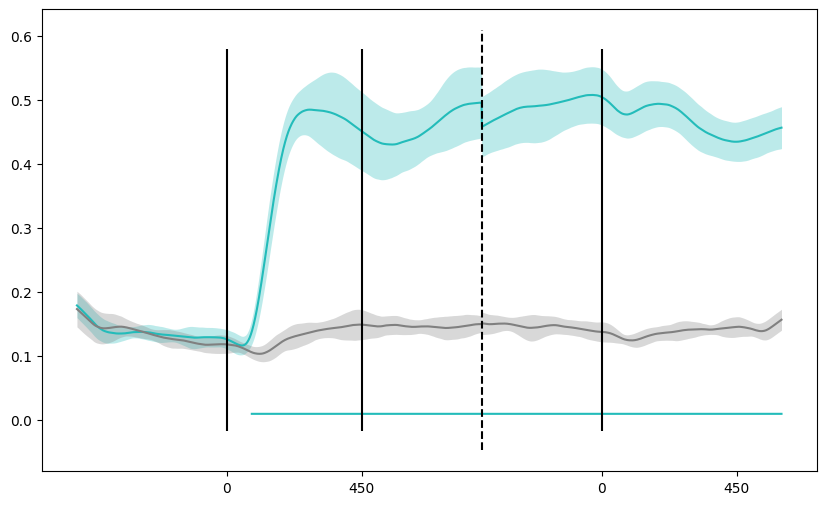

In [213]:
area='lip'
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=(res.distance['dist_n_nn'])
fd=(res.distance['dist_fake_n_nn'])

p = perm_test(d,fd)
p = np.where(p>0.95,True,np.nan)
latency,_=smetrics.find_latency(
    p_value=1-p, win=75, step= 1, p_treshold= 0.05
    )   
p[:latency]=np.nan
latency=latency-500/step

_=plt.plot(np.arange(len(p))-500/step,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-500/step,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-500/step,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0/step, 450/step, 1250/step, 1700/step])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0/step, 450/step, (450 + 400 + 400)/step],ax.get_ylim()[0],ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850/step],ax.get_ylim()[0],ax.get_ylim()[1],color="k",linestyles="--")

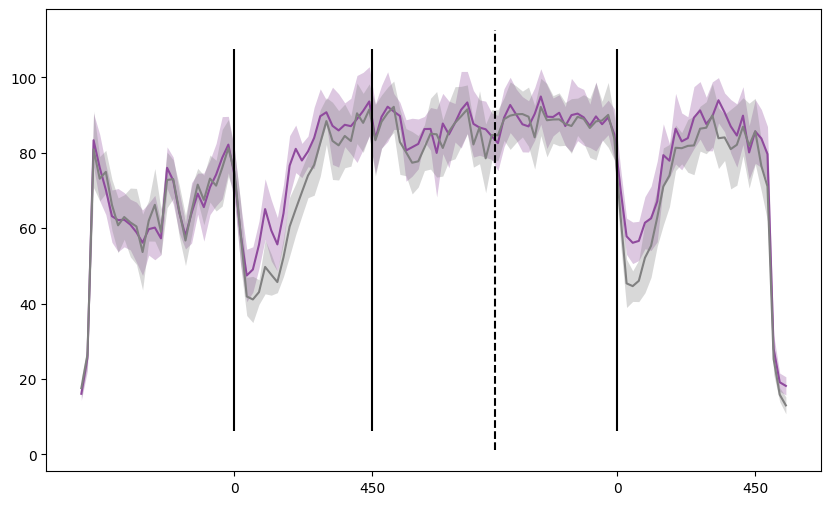

In [171]:
area='v4'
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=(res.distance['dist_n_nn'])*180/np.pi
fd=(res.distance['dist_fake_n_nn'])*180/np.pi

# p = perm_test(d,fd)
# p = np.where(p>0.95,True,np.nan)
# latency,_=smetrics.find_latency(
#     p_value=1-p, win=75, step= 1, p_treshold= 0.05
#     )   
# p[:latency]=np.nan
# latency=latency-500/step

_=plt.plot(np.arange(len(p))-500/step,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-500/step,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

#_=plt.plot(np.arange(len(p))-500/step,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0/step, 450/step, 1250/step, 1700/step])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0/step, 450/step, (450 + 400 + 400)/step],ax.get_ylim()[0],ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850/step],ax.get_ylim()[0],ax.get_ylim()[1],color="k",linestyles="--")

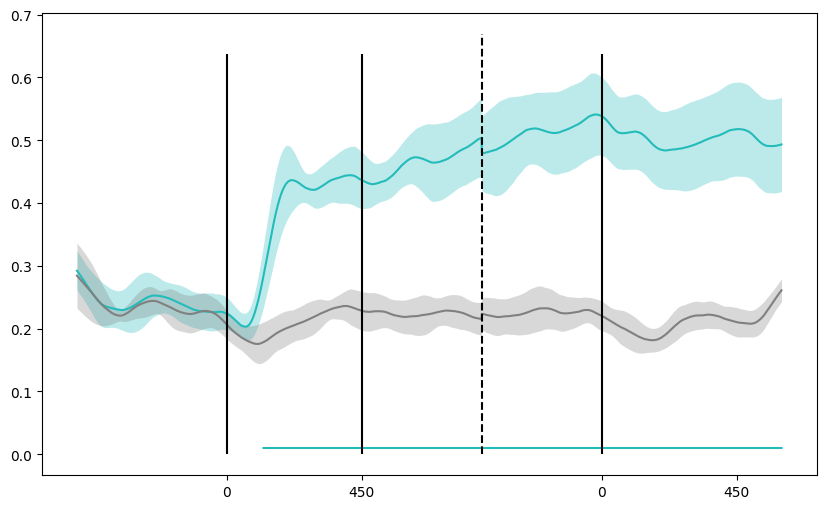

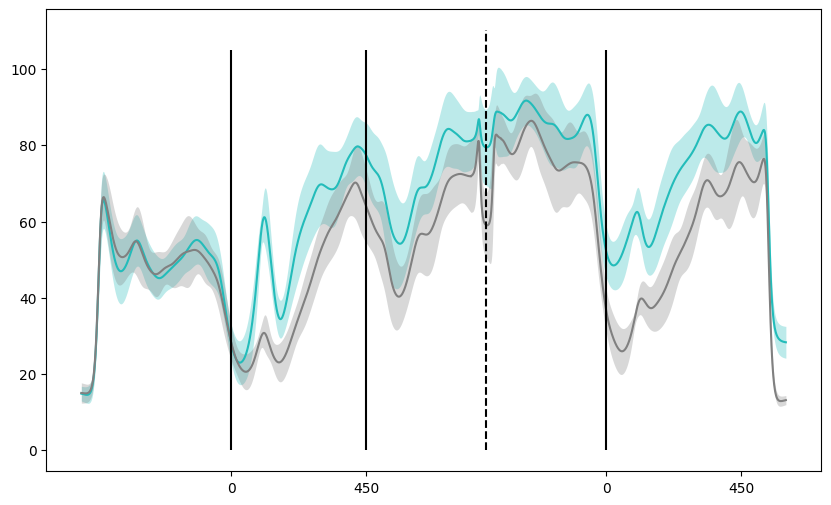

In [204]:
area='lip'
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=(res.distance['dist_n_nn'])
fd=(res.distance['dist_fake_n_nn'])

p = perm_test(d,fd)
p = np.where(p>0.95,True,np.nan)
latency,_=smetrics.find_latency(
    p_value=1-p, win=75, step= 1, p_treshold= 0.05
    )   
p[:latency]=np.nan
latency=latency-500/step

_=plt.plot(np.arange(len(p))-500/step,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-500/step,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p))-500/step,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-500/step,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0/step, 450/step, 1250/step, 1700/step])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0/step, 450/step, (450 + 400 + 400)/step],0,ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850/step],0,ax.get_ylim()[1],color="k",linestyles="--")
# -------------------------------
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=(res.distance['distv_n_nn'])*180/np.pi
fd=(res.distance['distv_fake_n_nn'])*180/np.pi

_=plt.plot(np.arange(len(p)-1)-500/step,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p)-1)-500/step,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p)-1)-500/step,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p)-1)-500/step,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

#_=plt.plot(np.arange(len(p))-500/step,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0/step, 450/step, 1250/step, 1700/step])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0/step, 450/step, (450 + 400 + 400)/step],0,ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850/step],0,ax.get_ylim()[1],color="k",linestyles="--")

In [56]:
#res.to_python_hdf5("lip_population_angle_distance.h5")

In [57]:
res_eucli = Results.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_distance/euclidean/percentile_with_nonzero/all_neurons/2024_09_24_21_18_55/in_rf/lip/population_distance.h5")
res_angle = Results.from_python_hdf5("lip_population_angle_distance.h5")

In [69]:
dang=(res_angle.distv_n_nn[:,300:-49])*180/np.pi
fdang=(res_angle.distv_fake_n_nn[:,300:-49])*180/np.pi

d=res_eucli.dist_n_nn
fd=res_eucli.dist_fake_n_nn

In [70]:
d.shape

(1000, 2000)

In [71]:
dang.shape

(1000, 2000)

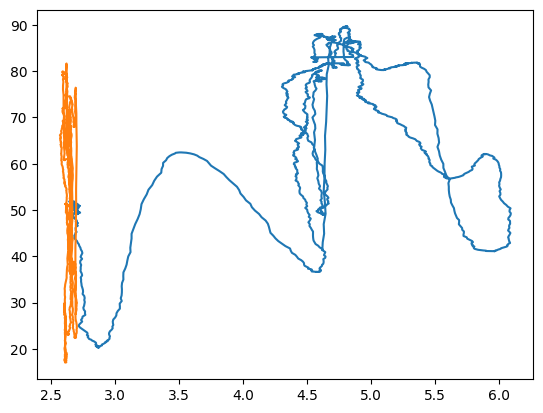

In [73]:
plt.plot(np.mean(d,axis=0),np.mean(dang,axis=0))
plt.plot(np.mean(fd,axis=0),np.mean(fdang,axis=0))

## Test neurons distributions

In [62]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    # min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        step=step,
        # n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]
    return fr_dicts_only

In [4]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 20,
    'step' : 2,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [63]:
def getparams(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):
    return input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric
input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric=getparams(**preprocessing, **paths)

TypeError: getparams() missing 1 required positional argument: 'min_sp_sec'

In [135]:
seed=1997
data = compute_distance(**preprocessing, **paths)

Compute distances


100%|██████████| 2122/2122 [00:19<00:00, 111.68it/s]


In [136]:
rng = np.random.default_rng(seed)
g1mean, g2mean = [], []
s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

for idata in data:
    meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
        scrum_neutralsize_samepool(idata, min_trials, rng)
    )

    s0mean.append(meanfr0)
    s11mean.append(meanfr11)
    s15mean.append(meanfr15)
    s51mean.append(meanfr51)
    s55mean.append(meanfr55)
    g1mean.append(g1)
    g2mean.append(g2)

neufr = {
    "0mean": s0mean,
    "11mean": s11mean,
    "15mean": s15mean,
    "51mean": s51mean,
    "55mean": s55mean,
    "g1mean": g1mean,
    "g2mean": g2mean,
}

fr_concat = np.concatenate(
    (
        neufr["0mean"],
        neufr["11mean"],
        neufr["15mean"],
        neufr["51mean"],
        neufr["55mean"],
    ),
    axis=1,
)
fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

n_neurons = fr_concat.shape[0]
idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
allsamp_fr = fr_concat[idx_neu]
fr_group_concat = fr_group_concat[idx_neu]
reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
reshape_pc = np.concatenate(
    (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
).reshape(select_n_neu, 2, -1)
fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)

dtime=1

v0 = np.diff(reshape_pc[:,0,:],n=dtime,axis=1) / dtime
v1 = np.diff(reshape_pc[:,1,:],n=dtime,axis=1) / dtime

v0g = np.diff(fr_groups[:,0,:],n=dtime,axis=1) / dtime
v1g = np.diff(fr_groups[:,1,:],n=dtime,axis=1) / dtime

In [137]:

v0 = convolve_signal(
    v0,fs = 1000,w_size=0.1,w_std=0.040,axis=-1
)
v1 = convolve_signal(v1,fs = 1000,w_size=0.1,w_std=0.040,axis=-1)

v0g = convolve_signal(
    v0g,fs = 1000,w_size=0.1,w_std=0.040,axis=-1
)
v1g = convolve_signal(v1g,fs = 1000,w_size=0.1,w_std=0.040,axis=-1)

Angle between the two vectors (in radians): nan
Angle between the two vectors (in degrees): nan


/tmp/ipykernel_117096/3909426122.py:16: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (norm_vec1 * norm_vec2)


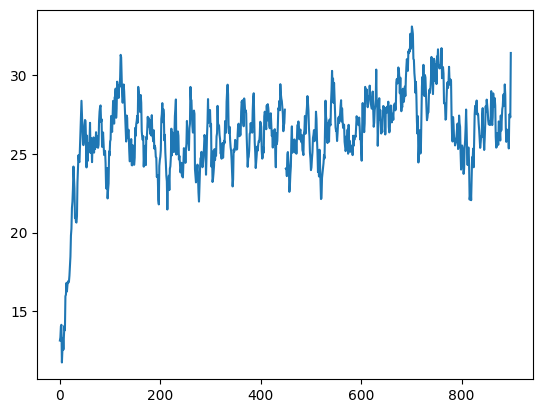

In [138]:
ang = []
angg = []
for i in range(900):
    vector1 = reshape_pc[:,0,i]
    vector2 = reshape_pc[:,1,i]

    # Compute the angle between the two vectors
    angle = compute_angle_between_vectors(vector1, vector2)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle)
    ang.append(angle_degrees)

    vector1 = fr_groups[:,0,i]
    vector2 = fr_groups[:,1,i]

    # Compute the angle between the two vectors
    angle = compute_angle_between_vectors(vector1, vector2)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle)
    angg.append(angle_degrees)
# plt.hist(vector1)
# plt.hist(vector2)
print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")
plt.figure()
plt.plot(ang)

In [139]:

ang = []
angg = []
for i in range(v0.shape[1]):
    vector1 = v0[:,i]
    vector2 = v1[:,i]

    # Compute the angle between the two vectors
    angle = compute_angle_between_vectors(vector1, vector2)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle)
    ang.append(angle_degrees)

    vector1 = v0g[:,i]
    vector2 = v1g[:,i]
    # plt.hist(vector1)
    # plt.hist(vector2)
    # Compute the angle between the two vectors
    angle = compute_angle_between_vectors(vector1, vector2)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle)
    angg.append(angle_degrees)

    print(f"Angle between the two vectors (in degrees): {angle_degrees}")

Angle between the two vectors (in degrees): 51.776828376029975
Angle between the two vectors (in degrees): 50.59714595286816
Angle between the two vectors (in degrees): 51.3040306275475
Angle between the two vectors (in degrees): 51.15208149423766
Angle between the two vectors (in degrees): 49.63031452923641
Angle between the two vectors (in degrees): 48.77015342569073
Angle between the two vectors (in degrees): 48.16608535539744
Angle between the two vectors (in degrees): 47.26625907243028
Angle between the two vectors (in degrees): 46.37199852658166
Angle between the two vectors (in degrees): 46.55750937650813
Angle between the two vectors (in degrees): 47.05788559650615
Angle between the two vectors (in degrees): 46.229566028659534
Angle between the two vectors (in degrees): 45.63885522866715
Angle between the two vectors (in degrees): 45.89002419276925
Angle between the two vectors (in degrees): 44.10844159414544
Angle between the two vectors (in degrees): 45.686127103404786
Angle 

[Text(0.0, 0, '0'),
 Text(225.0, 0, '450'),
 Text(625.0, 0, '0'),
 Text(850.0, 0, '450')]

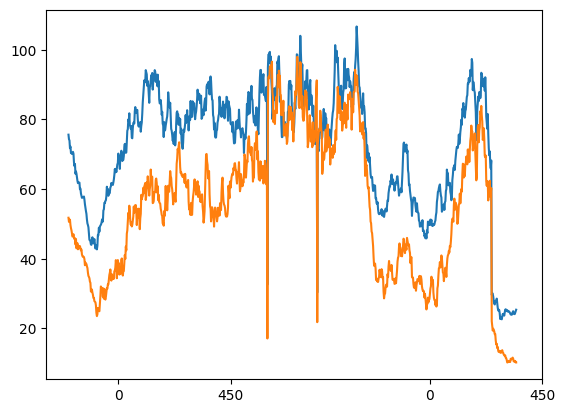

In [140]:
fig,ax=plt.subplots()
ax.plot(np.arange(len(ang))-200/step,ang)
ax.plot(np.arange(len(ang))-200/step,angg)
ax.set_xticks([0/step, 450/step, 1250/step, 1700/step])
ax.set_xticklabels(["0", "450", "0", "450"])

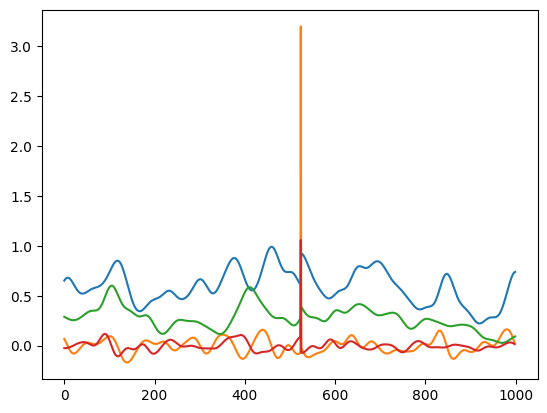

In [118]:
plt.plot(reshape_pc[0,0]/10)
plt.plot(v0[0])
plt.plot(reshape_pc[0,1]/10)
plt.plot(v1[0])

## Test distributions

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# Function to generate random samples and compute the average vector
def generate_vector(n_samples, dim, distribution=np.random.normal,loc=0):
    # Generate 'n_samples' vectors of dimension 'dim'
    samples = distribution(size=(n_samples, dim),loc=loc)
    
    return samples

# Function to generate random samples from a specified distribution and compute the average vector
def generate_average_vector(n_samples, dim, distribution_func,loc=None):
    # Generate 'n_samples' vectors of dimension 'dim' from the given distribution function
    samples = distribution_func(size=(n_samples, dim),loc=loc)
    # Compute the average vector
    avg_vector = np.mean(samples, axis=0)
    return avg_vector

Angle between the two vectors (in radians): 1.4044400911064325
Angle between the two vectors (in degrees): 80.4684897993674


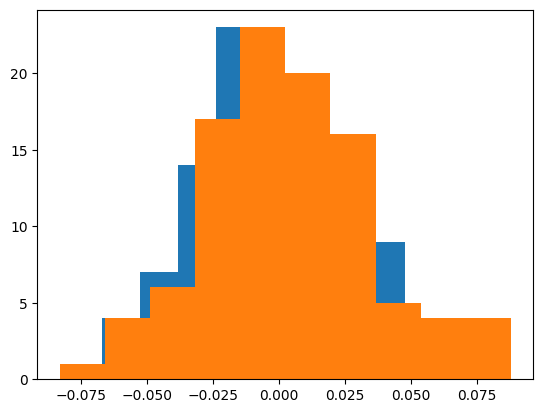

In [13]:
# Parameters
n_samples = 1000  # Number of samples for each vector
dim = 100         # Dimension of the vectors

# Generate two average vectors from the same distribution
samples = generate_vector(n_samples*2, dim,loc=0)
vector1 = np.mean(samples[:n_samples], axis=0)
vector2 = np.mean(samples[n_samples:], axis=0)

# Compute the angle between the two vectors
angle = compute_angle_between_vectors(vector1, vector2)

# Convert the angle from radians to degrees
angle_degrees = np.degrees(angle)

plt.hist(vector1)
plt.hist(vector2)
print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")

Angle between the two vectors (in radians): 0.6584050492230912
Angle between the two vectors (in degrees): 37.72383053058635


(array([ 12.,  62., 174., 298., 276., 137.,  33.,   6.,   1.,   1.]),
 array([49.90403082, 49.92943294, 49.95483506, 49.98023718, 50.0056393 ,
        50.03104142, 50.05644353, 50.08184565, 50.10724777, 50.13264989,
        50.15805201]),
 <BarContainer object of 10 artists>)

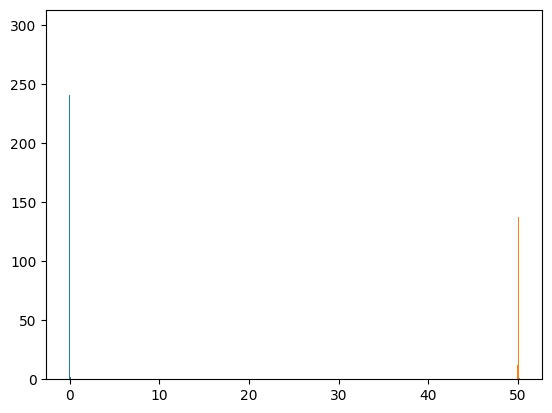

In [84]:
# Parameters
n_samples = 1000  # Number of samples for each vector
dim = 1000         # Dimension of the vectors

# Generate two average vectors, one from each different distribution
# For example, vector1 is from a normal distribution and vector2 from a uniform distribution

# Normal distribution for vector1
vector1 = generate_average_vector(n_samples, dim, np.random.normal,loc=0)#*100

# Uniform distribution for vector2 (between -1 and 1)
vector2 = generate_average_vector(n_samples, dim, np.random.normal,loc=50)#*100#generate_average_vector(n_samples, dim, lambda size: np.random.uniform(-10, 1, size=size))

# Compute the angle between the two vectors
angle = compute_angle_between_vectors(np.abs(vector1), np.abs(vector2))

# Convert the angle from radians to degrees
angle_degrees = np.degrees(angle)

print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")
plt.hist(vector1)
plt.hist(vector2)

In [287]:
# Function to generate random samples from a specified distribution and compute the average vector
def generate_average_vector2(n_samples, dim, distribution_func,loc1=None,loc2=None,scale=1):
    # Generate 'n_samples' vectors of dimension 'dim' from the given distribution function
    samples1 = distribution_func(size=(int(n_samples/2), dim),loc=loc1,scale=scale)
    samples2 = distribution_func(size=(int(n_samples/2), dim),loc=loc2,scale=scale)
    samples=np.concatenate((samples1,samples2),axis=0)
    # Compute the average vector
    avg_vector = np.mean(samples, axis=0)
    return avg_vector

Angle between the two vectors (in radians): 1.631752680026667
Angle between the two vectors (in degrees): 93.49254177468909


(array([  1.,   9.,  46., 126., 192., 263., 228.,  89.,  36.,  10.]),
 array([-11.57040099,  -9.42127577,  -7.27215055,  -5.12302534,
         -2.97390012,  -0.8247749 ,   1.32435031,   3.47347553,
          5.62260075,   7.77172596,   9.92085118]),
 <BarContainer object of 10 artists>)

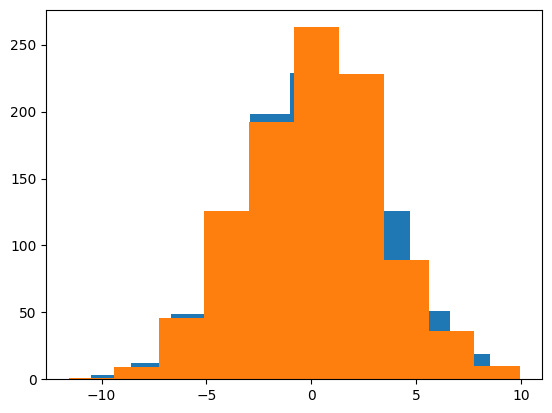

In [297]:
# Parameters
n_samples = 1000  # Number of samples for each vector
dim = 1000         # Dimension of the vectors

# Generate two average vectors, one from each different distribution
# For example, vector1 is from a normal distribution and vector2 from a uniform distribution

# Normal distribution for vector1
vector1 = generate_average_vector2(n_samples, dim, np.random.normal,loc1=-1,loc2=1,scale=100)#*100

# Uniform distribution for vector2 (between -1 and 1)
vector2 = generate_average_vector2(n_samples, dim, np.random.normal,loc1=-1,loc2=1,scale=100)#*100#*100#generate_average_vector(n_samples, dim, lambda size: np.random.uniform(-10, 1, size=size))

# Compute the angle between the two vectors
angle = compute_angle_between_vectors(vector1, vector2)

# Convert the angle from radians to degrees
angle_degrees = np.degrees(angle)

print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")
plt.hist(vector1)
plt.hist(vector2)

## Test subsampling and smoothing

In [14]:
input="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5"
popu = PopulationData.from_python_hdf5(input)

In [15]:
include_nid = None
if nidpath is not None:
    df_sel = pd.read_csv(nidpath)
    include_nid = df_sel["nid"].values

NameError: name 'nidpath' is not defined

In [16]:
neu=popu.population[0]

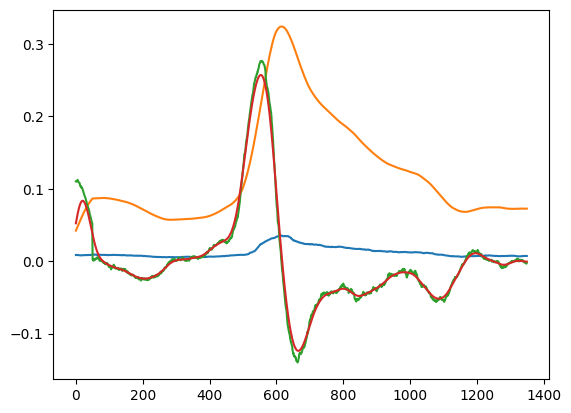

In [19]:
paths={
  'input': input,
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'step' : 1,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}
def getparams(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):
    return input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,min_sp_sec,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric
input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,min_sp_sec,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric=getparams(**preprocessing, **paths)
if include_nid is not None:
    nid = neu.get_neuron_id()
    if not (nid in include_nid):
        print(None)

idx_start_sample = int((getattr(neu, time_before_son) + start_sample))
idx_end_sample = int((getattr(neu, time_before_son) + end_sample))
idx_start_test = int((getattr(neu, time_before_t1on) + start_test))
idx_end_test = int((getattr(neu, time_before_t1on) + end_test))
sampleon = getattr(neu, sp_son)
t1on = getattr(neu, sp_t1on)
mask_son = getattr(neu, mask_son)

# Select trials aligned to sample onset

sample_id = neu.sample_id[mask_son].copy()

# Build masks to select trials with match in the n_test
mask_match = np.where(
    neu.test_stimuli[mask_son, n_test - 1] == neu.sample_id[mask_son],
    True,
    False,
)
mask_neu = neu.sample_id[mask_son] == 0
# Build masks to select trials with the selected number of test presentations
max_test = neu.test_stimuli[mask_son].shape[1]
mask_ntest = (max_test - np.sum(np.isnan(neu.test_stimuli[mask_son]), axis=1)) > (
    n_test - 1
)

if nonmatch:  # include neutral and trials without a match before n_ntest (included)
    mask_match_neu = np.logical_or(mask_ntest, mask_neu)
else:  # include neutral and trials with a match in the n_test
    mask_match_neu = np.logical_or(mask_match, mask_neu)
if np.sum(mask_match_neu) < 20:
    print(None)

#Average fr across time


# avg_sample_on = firing_rate.moving_average(
#     sampleon[mask_match_neu], win=avgwin, step=1
# )[:, idx_start_sample:idx_end_sample]
# avg_test1_on = firing_rate.moving_average(t1on[mask_match_neu], win=avgwin, step=1)[
#     :, idx_start_test:idx_end_test
# ]
avg_sample_on = firing_rate.moving_average(
    sampleon[mask_match_neu], win=avgwin, step=step
)
plt.plot(np.mean(avg_sample_on,axis=0)[:int(idx_end_sample/step)])

conv_sample_on = convolve_signal(
    avg_sample_on,fs = 1000/step,w_size=0.1,w_std=0.040,axis=-1
)
conv_sample_on_mean = np.mean(conv_sample_on,axis=0)
plt.plot((conv_sample_on_mean[:int(idx_end_sample/step)])/100)

vv = np.diff(conv_sample_on_mean )
dtime=1
plt.plot((vv[:int(idx_end_sample/step)])/ dtime)


vv_smooth = convolve_signal(
    vv/ dtime,fs = 1000/step,w_size=0.1,w_std=0.015,axis=-1
)/1000
plt.plot(vv_smooth[:int(idx_end_sample/step)])


In [37]:
sample_id = neu.sample_id[mask_son][mask_match_neu]
samples = [0, 11, 15, 55, 51]

if norm == True:
    conv_sample_on = conv_sample_on / np.max(conv_sample_on)
if zscore == True:
    sp_std = np.std(conv_sample_on, ddof=1, axis=0)
    sp_std = np.where(sp_std == 0, 1, sp_std)
    conv_sample_on = (conv_sample_on - np.mean(conv_sample_on, axis=0).reshape(1, -1)) / sp_std.reshape(1, -1)
# Get trials grouped by sample
fr_samples = select_trials.get_sp_by_sample(conv_sample_on, sample_id, samples=samples)

In [39]:
conv_sample_on_mean = np.mean(fr_samples['0'][:25],axis=0)
vv = np.diff(conv_sample_on_mean )
dtime=1
vv_smooth0 = convolve_signal(
    np.abs(vv)/ dtime,fs = 1000/step,w_size=0.1,w_std=0.015,axis=-1
)
conv_sample_on_mean = np.mean(fr_samples['11'][:25],axis=0)
vv = np.diff(conv_sample_on_mean )
dtime=1
vv_smooth1 = convolve_signal(
    np.abs(vv)/ dtime,fs = 1000/step,w_size=0.1,w_std=0.015,axis=-1
)

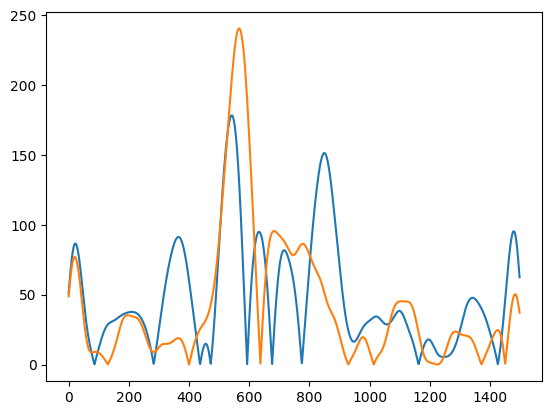

In [31]:
plt.plot(np.abs(vv_smooth0)+0.001)
plt.plot(np.abs(vv_smooth1)+0.001)

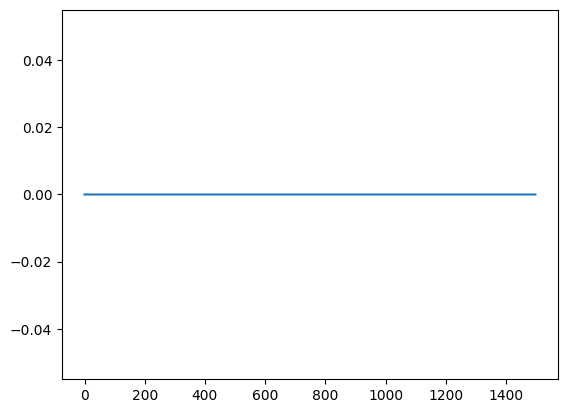

In [51]:
angle=[]
for i in range(len(arr0)):
    angle.append(compute_angle_between_vectors(vv_smooth0[i], vv_smooth1[i]))
plt.plot(angle)

### Compare N and NN speed

In [5]:
def get_speed(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []



    distv_n_nn,distv_fake_n_nn=[],[]
    dtime=1

    v0 = (np.diff(reshape_pc[:,0,:],n=dtime,axis=1) / dtime)
    v0 = convolve_signal(v0,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
    v1 = (np.diff(reshape_pc[:,1,:],n=dtime,axis=1) / dtime)
    v1 = convolve_signal(v1,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

    v0g = (np.diff(fr_groups[:,0,:],n=dtime,axis=1) / dtime)
    v0g = convolve_signal(v0g,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
    v1g = (np.diff(fr_groups[:,1,:],n=dtime,axis=1) / dtime)
    v1g = convolve_signal(v1g,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)


                    

    return {
        "vel_n": v0,
        "vel_nn": v1,
        "vel_g0": v0g,
        "vel_g1": v1g,
        "n_neurons": n_neurons,
    }


In [37]:
def compute_speed(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    seed=1997
    res = {}
    rng = np.random.default_rng(seed)
    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        step=step,

        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]
    print("start iterations")
    distance_data = []
    for _ in tqdm(range(1)):
        dist = get_speed(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_vel_n=[]
    all_vel_nn=[]
    all_vel_g0=[]
    all_vel_g1=[]
    all_n_neurons=[]
    for asc in distance_data:
        all_vel_n.append(asc["vel_n"])
        all_vel_nn.append(asc["vel_nn"])
        all_vel_g0.append(asc["vel_g0"])
        all_vel_g1.append(asc["vel_g1"])
    all_vel_n = np.array(all_vel_n, dtype=np.float32)
    all_vel_nn = np.array(all_vel_nn, dtype=np.float32)
    all_vel_g0 = np.array(all_vel_g0, dtype=np.float32)
    all_vel_g1 = np.array(all_vel_g1, dtype=np.float32)
    res["vel_n"] = all_vel_n
    res["vel_nn"] = all_vel_nn
    res["n_neurons"] = asc["n_neurons"]
    res["vel_g0"] = all_vel_g0
    res["vel_g1"] = all_vel_g1


    res = Results("population_vel.py", input, distance=res)
    return res

In [38]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 20,
    'step' : 2,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [39]:
def getparams(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    step,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):
    return input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric
input,sp_son,sp_t1on,mask_son,start_sample,end_sample,start_test,end_test,time_before_son,time_before_t1on,avgwin,step,n_test,min_trials,nonmatch,norm,zscore,select_n_neu,nidpath,percentile,cerotr,metric=getparams(**preprocessing, **paths)

In [40]:
seed=1997
data = compute_speed(**preprocessing, **paths)

Compute distances














































100%|██████████| 530/530 [00:04<00:00, 116.09it/s]


start iterations






100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


In [ ]:
data.

In [48]:
print(np.mean(data.distance['vel_n']))
print(np.mean(data.distance['vel_nn']))

-0.21706168
-0.1326262


In [50]:
np.mean(data.distance['vel_n'],axis=(0,1)).shape

(1, 100, 1199)

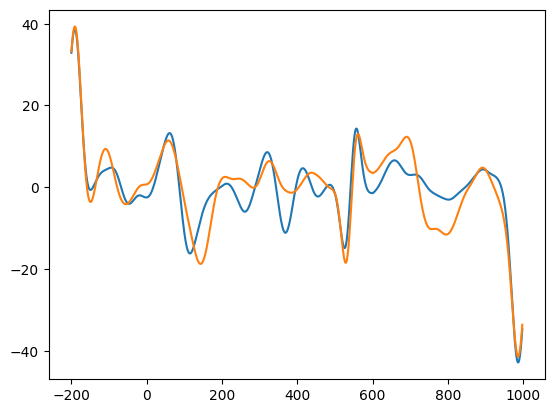

In [55]:
plt.plot(np.arange(1199)-200,np.mean(data.distance['vel_n'],axis=(0,1)))
plt.plot(np.arange(1199)-200,np.mean(data.distance['vel_nn'],axis=(0,1)))